In [22]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12),
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [23]:
import pandas as pd
import os

def load_police_data():
    csv_path = os.path.join(os.path.join("police_data"), "crimes_2012_to_2017.csv")
    return pd.read_csv(csv_path, index_col=0)

## Load Data and get basic info about shape and values

In [24]:
police_data = load_police_data()
print(f'Shape of table: {police_data.shape}')
# Show Unique value count for each column
print(f'Unique values per column: \n{police_data.nunique()}')
police_data.tail(2)

Shape of table: (1456714, 22)
Unique values per column: 
ID                      1456714
Case Number             1456598
Date                     582146
Block                     32774
IUCR                        365
Primary Type                 33
Description                 342
Location Description        142
Arrest                        2
Domestic                      2
Beat                        302
District                     24
Ward                         50
Community Area               78
FBI Code                     26
X Coordinate              67714
Y Coordinate             111555
Year                          6
Updated On                  959
Latitude                 368076
Longitude                367942
Location                 368286
dtype: int64


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,...,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


## Format Data, drop/rename/add columns, convert to timeseries etc

In [25]:
drop_attributes = ['Location',
                   'ID',
                   'Case Number',
                   'IUCR',
                   'Block',
                   'Ward',
                   'Primary Type',
                   'Beat',
                   'X Coordinate',
                   'Community Area',
                   'Year',
                   'Latitude',
                   'Longitude',
                   'Y Coordinate',
                   'Updated On',
                   'Description',
                   'Location Description']

police_data = police_data.drop(columns=drop_attributes)

# Rename columns
police_data.rename(columns={
    'Arrest': 'Arrest Status',
    'Domestic': 'Domestic Status'
}, inplace=True)

# Convert to timeseries
# A lot (X50) faster when we provide the format
police_data['Date'] = pd.to_datetime(
    police_data['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Set datetime as index, will not remove duplicates (verify_integrity=True would remove duplicates)
police_data = police_data.set_index('Date')

# Generate temp columns for plotting distributions
police_data['Year'] = police_data.index.year
police_data['Month'] = police_data.index.month
police_data['Day of the Year'] = police_data.index.day_of_year

# Drop rows with null values
police_data= police_data.dropna()
print(f'Shape of table: {police_data.shape}')

# Show Unique value count for each column
print(f'Unique values per column: \n{police_data.nunique()}')


Shape of table: (1456713, 7)
Unique values per column: 
Arrest Status        2
Domestic Status      2
District            24
FBI Code            26
Year                 6
Month               12
Day of the Year    366
dtype: int64


## Visualize Categorical Values

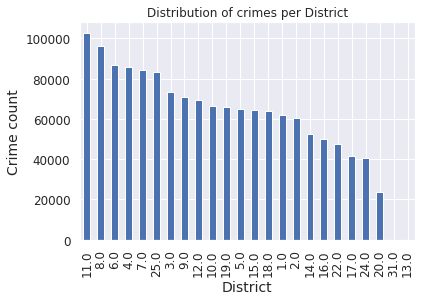

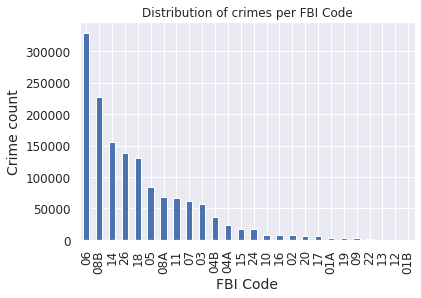

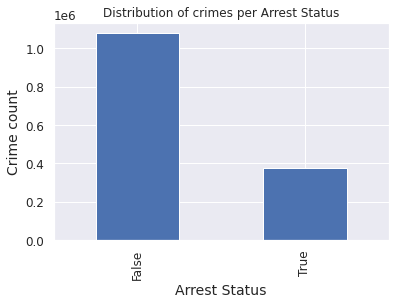

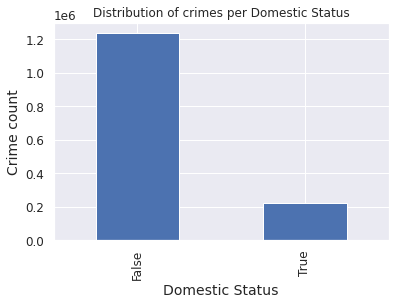

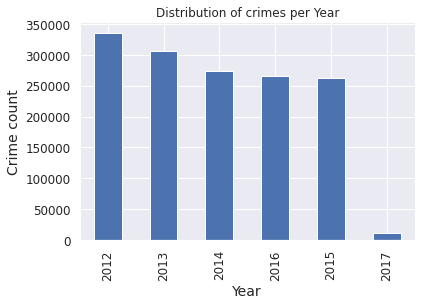

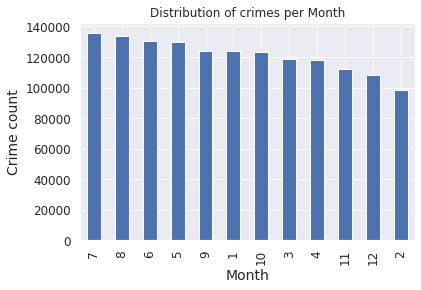

In [26]:
# Print bar diagrams for important columns
columns_hist = [
    'District',
    'FBI Code',
    'Arrest Status',
    'Domestic Status',
    'Year',
    'Month',
]

for column in columns_hist:
    police_data[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of crimes per {column}')
    plt.xlabel(column)
    plt.ylabel('Crime count')
    plt.show()

drop_attributes = [
    'Year',
    'Month',
    'Day of the Year'
]

police_data = police_data.drop(columns=drop_attributes)


## Timeseries Visualisation

In [27]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10), 'lines.marker':'o', 'lines.linewidth': 0.5})
# comment out to see all possible keys
# mpl.rcParams.keys()

# this helps with adding plot ticks on certain weekdays etc
import matplotlib.dates as mdates

Text(0.5, 1.0, 'Weekly crime count across 5 years')

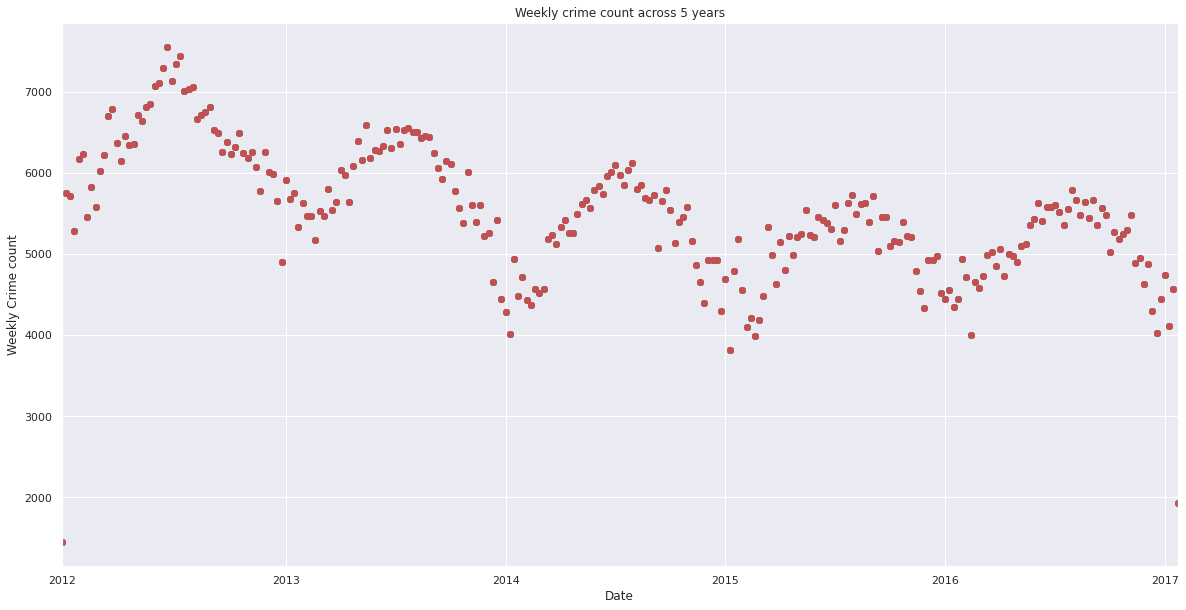

In [28]:
ax = police_data.resample('1W').count().plot(linestyle='None', legend=False)
ax.set_ylabel('Weekly Crime count')
ax.set_title('Weekly crime count across 5 years')

Text(0.5, 1.0, 'Daily crime count over the years 2015-2016')

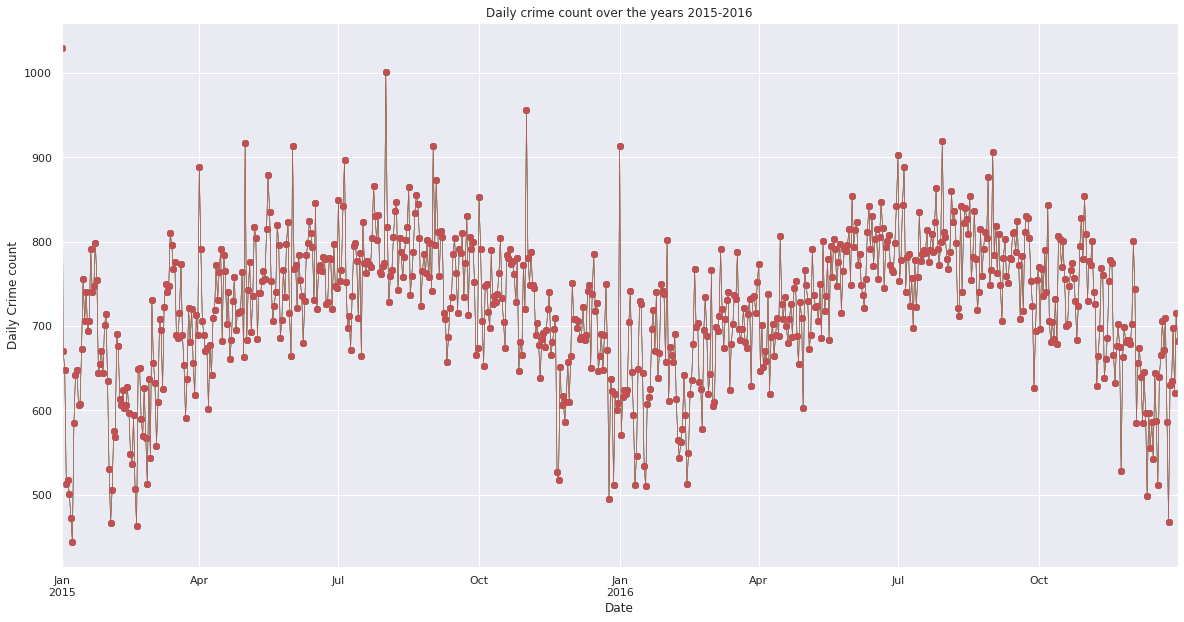

In [29]:
ax = police_data.loc['2015':'2016'].resample('1d').count().plot(linestyle='-', legend=False)
ax.set_ylabel('Daily Crime count')
ax.set_title('Daily crime count over the years 2015-2016')

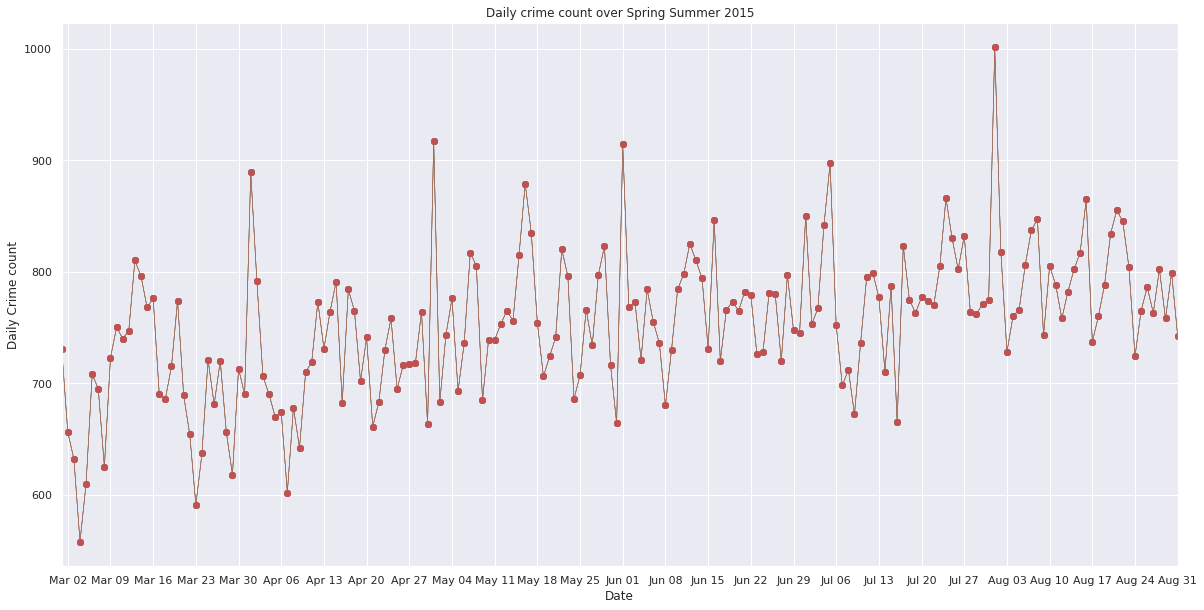

In [30]:
ax = police_data.loc['2015/03':'2015/08'].resample('1d').count().plot(linestyle='-', legend=False)
ax.set_ylabel('Daily Crime count')
ax.set_title('Daily crime count over Spring Summer 2015')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## Autoregressive Integrated Moving Average Model

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series
  stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


### Prepare Series, select period

In [31]:
# remove all columns
print(f'Shape of table: {police_data.shape}')
drop_attributes = [
    'Arrest Status',
    'Domestic Status',
    'District',
    'FBI Code'
]
police_data = police_data.drop(columns=drop_attributes)


Shape of table: (1456713, 4)


In [44]:
# Create period table, with one column for crime count
print(f'Shape of table before resampling: {police_data.shape}')

police_data['Crime Count'] = ""
# table with monthly period, skip 2017 data cause they are too little
series = police_data.loc[:'2016/12'].resample(rule='1d', kind='period').count()
print(f'Shape of period array: {series.shape}')
print(series.info())
series.tail(2)


Shape of table before resampling: (1456713, 1)
Shape of period array: (1827, 1)
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1827 entries, 2012-01-01 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Crime Count  1827 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB
None


,Crime Count
Date,
2016-12-30,716
2016-12-31,682


### Get Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

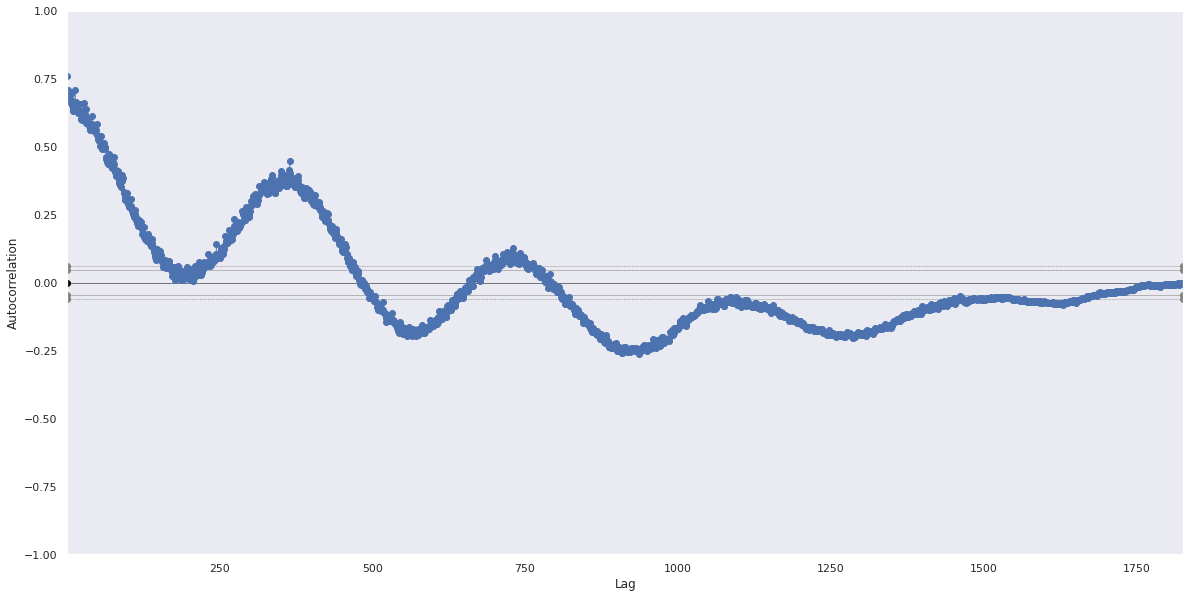

In [45]:
from pandas.plotting import autocorrelation_plot
# This can help as choose the lag to be used in the Arima model, p value
autocorrelation_plot(series)

### First try of training the ARIMA model

                               SARIMAX Results                                
Dep. Variable:            Crime Count   No. Observations:                 1827
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10381.795
Date:                Sun, 29 May 2022   AIC                          20775.591
Time:                        01:08:55   BIC                          20808.650
Sample:                    01-01-2012   HQIC                         20787.785
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5835      0.016    -37.095      0.000      -0.614      -0.553
ar.L2         -0.4496      0.024    -18.877      0.000      -0.496      -0.403
ar.L3         -0.3432      0.024    -14.021      0.0

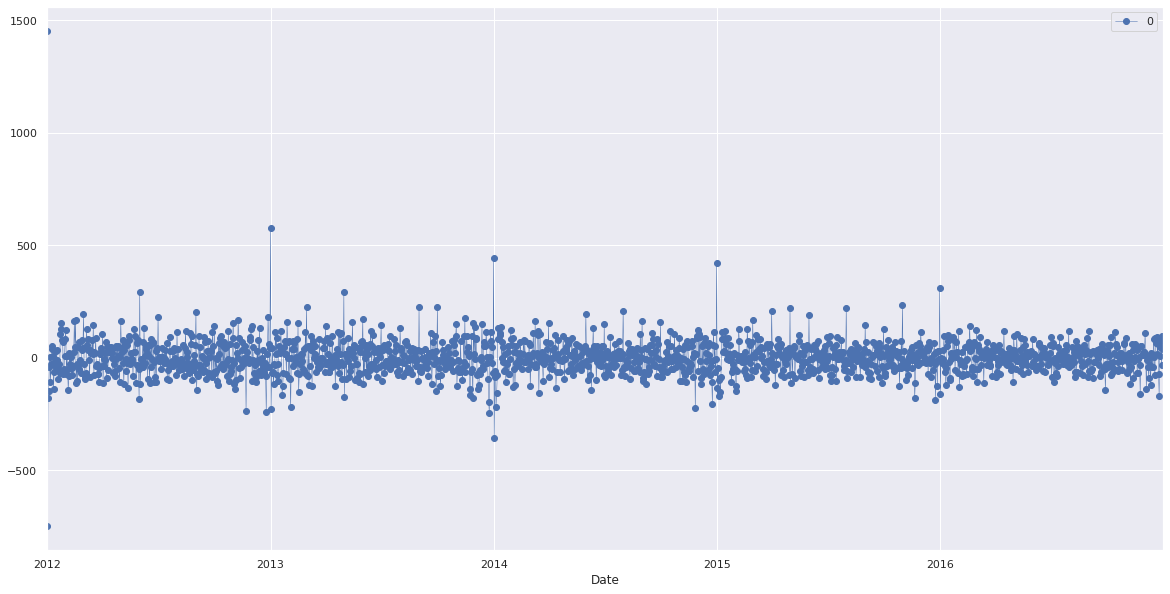

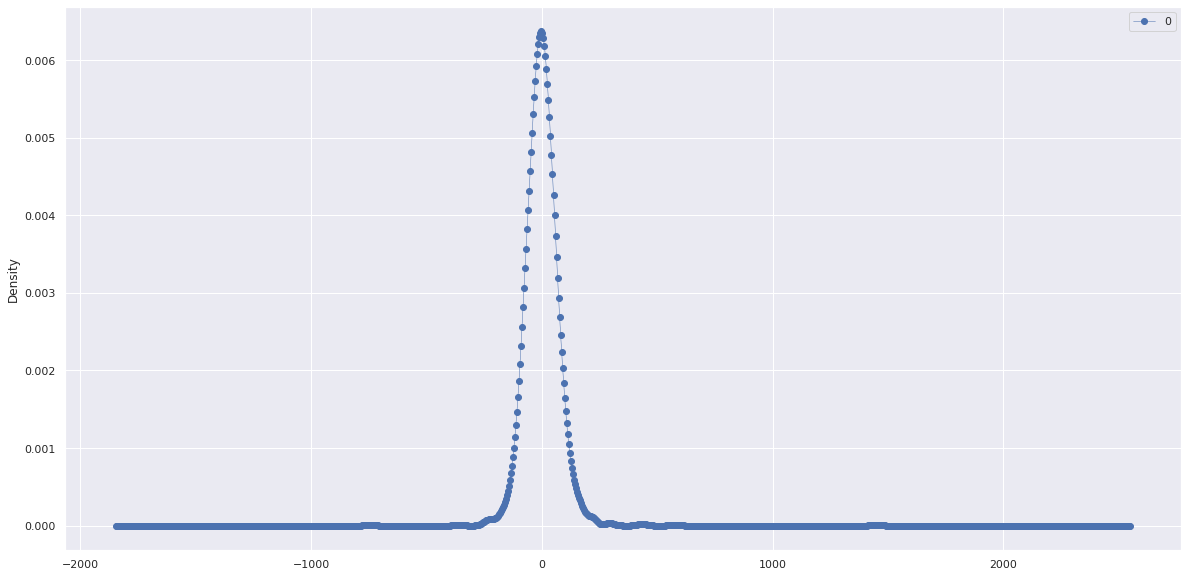

                 0
count  1827.000000
mean     -0.143498
std      79.489371
min    -747.160935
25%     -42.564348
50%      -1.926852
75%      39.917743
max    1451.000000


In [46]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Split series in train and validation sets, then run a walk-forward train and validation - same hyperparameters as in previous step


predicted=732.799487, expected=741.000000
predicted=747.618971, expected=661.000000
predicted=698.615563, expected=683.000000
predicted=709.778128, expected=730.000000
predicted=721.837637, expected=758.000000
predicted=725.530957, expected=695.000000
predicted=712.009308, expected=716.000000
predicted=707.392233, expected=717.000000
predicted=714.035629, expected=718.000000
predicted=719.592984, expected=764.000000
predicted=742.457876, expected=663.000000
predicted=697.341680, expected=917.000000
predicted=797.263450, expected=683.000000
predicted=732.277819, expected=743.000000
predicted=739.748649, expected=776.000000
predicted=767.986872, expected=693.000000
predicted=718.328661, expected=736.000000
predicted=761.652760, expected=817.000000
predicted=760.632359, expected=805.000000
predicted=775.638963, expected=685.000000
predicted=737.460371, expected=739.000000
predicted=738.098881, expected=739.000000
predicted=744.776347, expected=753.000000
predicted=756.436477, expected=765

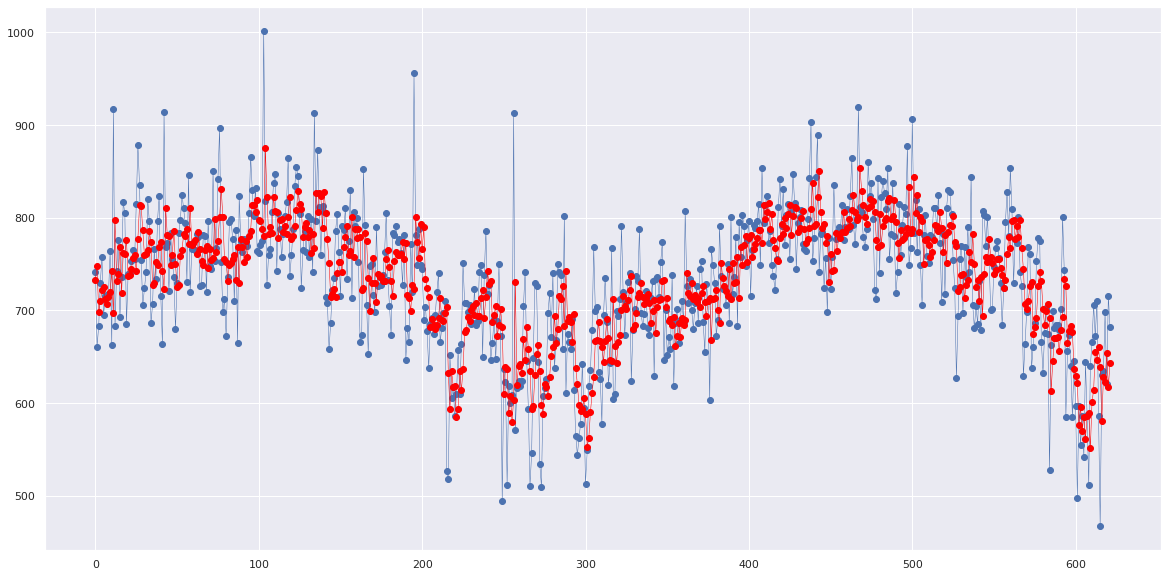

In [47]:
from sklearn.metrics import mean_squared_error


def walk_forward_train_evaluate_and_report(series, arima_order):
    # split into train and validation sets
    X = series.values
    size = int(len(X) * 0.66)
    train, validation = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(validation)):
        model = ARIMA(history, order=arima_order)
        # print('Fitting on:')
        # print(history)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = validation[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    mse = mean_squared_error(validation, predictions)
    print('validation MSE: %.3f' % mse)
    # plot forecasts against actual outcomes
    plt.plot(validation)
    plt.plot(predictions, color='red')
    plt.show()


walk_forward_train_evaluate_and_report(series, (5, 1, 0))


### ARIMA hyperparameters tuning with the Grid Search Method

#### The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.


In [50]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [51]:
# supress errors noise
import warnings
warnings.filterwarnings("ignore")

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg


In [55]:
# Split training/validation set and final test set
train_size = int(len(series) * 0.75)
train_series, test_series = series[0:train_size], series[train_size:]

In [56]:
# evaluate parameters
p_values = [8, 10, 12]
d_values = range(0, 3)
q_values = range(0, 3)
best_cfg = evaluate_models(train_series.values, p_values, d_values, q_values)


ARIMA(8, 0, 0) MSE=4757.729
ARIMA(8, 0, 1) MSE=4624.164
ARIMA(8, 0, 2) MSE=4614.190
ARIMA(8, 1, 0) MSE=4737.302
ARIMA(8, 1, 1) MSE=4608.450
ARIMA(8, 1, 2) MSE=4643.516
ARIMA(8, 2, 0) MSE=5857.756
ARIMA(8, 2, 1) MSE=4740.611
ARIMA(8, 2, 2) MSE=4786.666
ARIMA(10, 0, 0) MSE=4736.853
ARIMA(10, 0, 1) MSE=4753.786


###  We found the best hyperparameter combination, we can now evaluate the model against the previously unseen test series

In [41]:
walk_forward_train_evaluate_and_report(test_series, best_cfg)

LinAlgError: LU decomposition error.